In [9]:
import string
import urllib2
import json
import re
import io
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import copy
import nltk, re, pprint
import os
import time
import calendar
import datetime
#import community
from threading import Thread
from time import sleep
from __future__ import division
import codecs
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


<h1> Choosing the data

We've decided to look at movie data. In regards to doing this, we started by looking at IMDB's data on movies. From them we downloaded a list of all their movies. This summed up to a total of 4,5 million movies/TV shows/short/video etc, etc, etc....
Using regular expressions we removed everything we didn't want, so we only had Movies left. This left us with a total of 300.000 different movies. Since IMDB only gave us titles, runtime and score, we needed to find more information in other places. So we went to https://www.themoviedb.org/. They gave us everything we needed to make our analysis. From them we downloaded Json files on our movies, which also contained some specific information. This left us with 4.500 movies. These are then the movies we worked with.

We chose this data because we would like to work with movies and figure out different things and trends about the movie business. For example, which pair of actors make the movie with the highest scores, or is there a correlation between a movies score and the money it makes.

We envisioned that we at the end could have some data which could show users different trends in the movie business. As a part of this, we also wanted to show users which different parameters is the best if you want to make money on your movie.

<h1> Cleaning up the data.

We started with 4.500.000 lines of different IMDB content, which contained only 329.820 usable movies. From that we only got 4.398 actual movies we could use. This took some regular expression, and a lot of API calls to https://www.themoviedb.org/. They only allow 4 calls per second, so the process took some planning to make 329.820 calls, which took almost 23 hours before we could get down to our 8.460 movies. And from those only 4.398 movies contained all the data we wanted.

Afterwards we made a lot of data processing to get the right information in the right format and iterable in folders. It's possible to see everything in our Downloader Notebook. In there it's possible to see our code which does :
* Select the right movies from all movies
* Get Data from MovieDB
* Get Reviews for all movies
* Get Credits
* Get all Actors from Credits
* Get all directors from Credits
* Actors in more than 1 movie
* Actors in more than X movies
* All Actor pairs
* All Director and Actor Pair


So after this has been ran, we ended up with :
* 4.398 movies and credits
* 51.137 Actors
* 15.085 Actors in more than 1 movie.
* 1.407 Actors in 10 or more movies.
* 2.021 Directors.
* 2.018 Pairs of Actor/Directors who have been in 2 or more movies together.
* 2.231 Pairs of Actor/Actor who have been in 3 or more movies together.

For the last two points, the lists of pairs, we decided that we wanted a minimum of movies people we in together. We did this because we didn't want one-hit wonders. For example if we didn't have a minimum on Director/Actor, the best pairs would have been the director of the highest grossing movie and everyone who only worked with him on that movie. In this case it would be James Cameron for Avatar, and whatever extra was in only this Avatar.

For the rest of the data, we didn't make any limits after we got the 4.398 movies. So we can see every director in average makes a little over 2 movies, and each movie have in average have 11 actors. 

<h2> Graph of all actors

In [89]:
actorGraph = nx.Graph()
revenueList = []
for filename in os.listdir('ActorsMoreThan1'):
    #print filename[:-4]
    fileOpen = io.open("ActorsMoreThan1/" + filename, 'r', encoding='utf-8')
    doneList = fileOpen.readlines()
    doneList = [x.strip() for x in doneList]
    fileOpen.close()
    rev = 0
    for line in doneList:
        filmen = io.open("MovieDBID/" + line + ".txt", 'r', encoding='utf-8')
        filmJson = json.load(filmen)
        rev = rev + filmJson["revenue"]
    rev = rev / len(doneList)
    actorGraph.add_node(filename[:-4], revenue = rev)
    revenueList.append([filename[:-4], rev])
    #break

In [90]:
for filename in os.listdir('Credits'):
    fileOpen = io.open("Credits/" + filename, 'r', encoding='utf-8')
    sidensJson = json.load(fileOpen)
    fileOpen.close()
    for i in sidensJson["cast"]:
        try:
            actorGraph.node[str(i["id"])]
            for j in sidensJson["cast"]:
                try:
                    actorGraph.node[str(j["id"])]
                    if (i["id"] != j["id"]):
                        #print i["id"], j["id"]
                        actorGraph.add_edge(str(i["id"]),str(j["id"]))
                except:
                    pass
        except:
            pass
    #break
for i in actorGraph.nodes():
    if actorGraph.degree(i) == 0:
        actorGraph.remove_node(i)
        print i

In [92]:
actorGiant = max(nx.connected_component_subgraphs(actorGraph), key=len)
actorPartition = community.best_partition(actorGiant)
print (len(actorGraph.nodes()) - len(actorGiant.nodes()))

3


We take the giant component so we have the biggest connected Graph component. From above we can see we only lose 3 nodes, so that means there was a second subgraph of only 3 nodes, which were only connected to eachother. We remove these because they are not important for the bigger picture and only modify our later results for the worse.

We also make partitions on the Graph for which we are going to use later on.

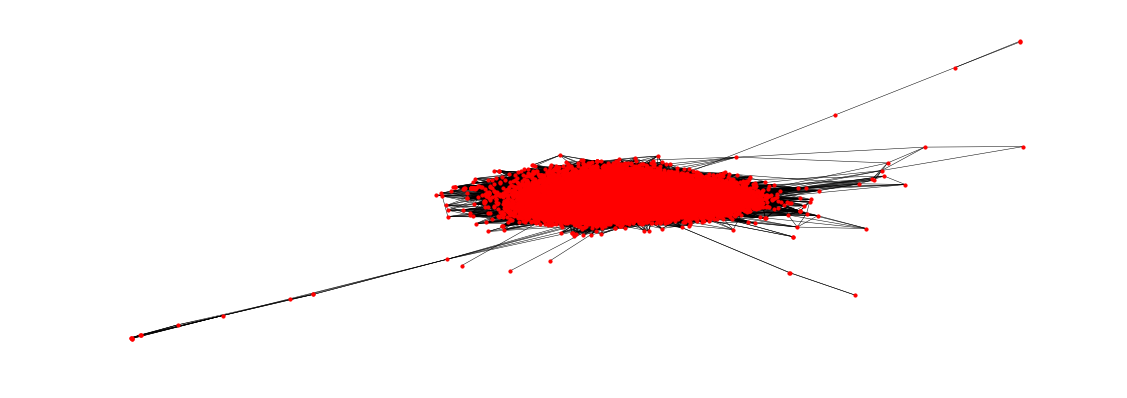

In [93]:
nx.draw(actorGiant, node_size = 10, width = 0.5)

plt.show()

Above the Graph can be seen for all actors in more than 1 movie. It's clear that most actors stay in one big group, while some actors are far from the group, either in small groups or alone. These actors are probably extras in very few movies.

In [97]:
actorBetweenCent = nx.betweenness_centrality(actorGiant)

In [104]:
from collections import Counter
peopleList = Counter(actorBetweenCent).most_common(5)
for i in peopleList:
    person = io.open("PersonJson/" + i[0] + ".txt", 'r', encoding='utf-8')
    nameJson = json.load(person)
    nameDone = nameJson["name"]
    person.close()
    print nameDone, i[1]

Samuel L. Jackson 0.00807064658297
Bruce Willis 0.00614743483376
Morgan Freeman 0.00517944959836
Nicolas Cage 0.00494345463636
Robert De Niro 0.00461221646461


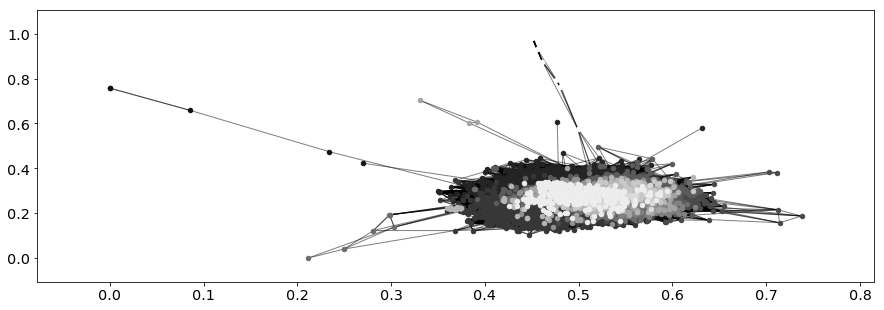

In [103]:
size = float(len(set(actorPartition.values())))
pos = nx.spring_layout(actorGiant)
count = 0.
for com in set(actorPartition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in actorPartition.keys()
                                if actorPartition[nodes] == com]
    nx.draw_networkx_nodes(actorGiant, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
nx.draw_networkx_edges(actorGiant,pos, alpha=0.5)
plt.show()

Above can be seen the same graph, but now with different colors for each partition. It's possible to see the individual groups of actors in the graph.

In [105]:
communitiesNumber = max(actorPartition.values())
print "Number of communities : ", communitiesNumber

Number of communities :  13


Above we can see we have a total of 13 partitions. Below it's possible to see the amount of actors in each partition. It's clear that not all partitions are of the same size, so the partition is not the best.

In [106]:
testList = actorPartition.values()
for i in set(actorPartition.values()):
    print testList.count(i)

2110
3041
4084
1754
1395
890
192
413
235
341
171
103
339
14


In [107]:
testList = []
for i in set(actorPartition.values()):
    testList.append([])
for node, part in actorPartition.iteritems():
    testList[part].append(node)
M = 0.0
for i in testList:
    Lc = 0.0
    L = len(actorGiant.edges())
    Kc = 0.0
    for j in i:
        Kc = Kc + actorGiant.degree(j)
        for l in actorGiant[j].keys():
            if l in i:
                Lc = Lc + 1        
    print "Lc =", Lc, ",", "L =", L, "Kc =", Kc
    tempM = ((Lc / L) - (Kc/(2*L))**2)
    M = M + tempM
    print "M =", tempM
print "Sum Modularity for all the branches :", M

Lc = 97398.0 , L = 670936 Kc = 204681.0
M = 0.121900750709
Lc = 163248.0 , L = 670936 Kc = 249944.0
M = 0.208619109249
Lc = 198660.0 , L = 670936 Kc = 333569.0
M = 0.234299406024
Lc = 70478.0 , L = 670936 Kc = 152660.0
M = 0.0921014935198
Lc = 50204.0 , L = 670936 Kc = 106645.0
M = 0.0685105663248
Lc = 33828.0 , L = 670936 Kc = 93024.0
M = 0.0456132922404
Lc = 7052.0 , L = 670936 Kc = 22127.0
M = 0.0102387809778
Lc = 14668.0 , L = 670936 Kc = 41336.0
M = 0.0209130646024
Lc = 6624.0 , L = 670936 Kc = 21870.0
M = 0.00960714581344
Lc = 14712.0 , L = 670936 Kc = 37795.0
M = 0.0211342592488
Lc = 5562.0 , L = 670936 Kc = 19898.0
M = 0.00807002586687
Lc = 6692.0 , L = 670936 Kc = 16610.0
M = 0.00982090512564
Lc = 15262.0 , L = 670936 Kc = 41632.0
M = 0.0217847560215
Lc = 76.0 , L = 670936 Kc = 81.0
M = 0.000113270945785
Sum Modularity for all the branches : 0.872726826669


The sum of modularity is actually quite high, which means the partition is good. This also means our total actor graph contains different partitions. This means there exists groups inside the movie business where people stay inside and make movies.

In [108]:
d = list(actorGraph.degree().values())
averageDegree = numpy.average(d)
print averageDegree
medianDegree = numpy.median(d)
print medianDegree

88.9544580709
62.0


In [109]:
limitedInList = Counter(d).most_common(10)
print limitedInList

[(35, 218), (37, 212), (34, 207), (40, 202), (47, 199), (43, 198), (45, 198), (41, 197), (36, 194), (44, 190)]


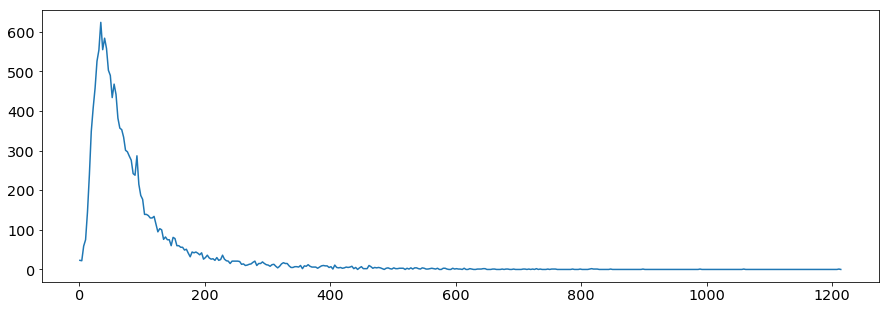

In [126]:
degreeValues = actorGraph.degree().values()
degreeBins,degreeBins_edges = numpy.histogram(degreeValues, bins=400)
degreeBins = numpy.append(degreeBins,0)
plt.plot(degreeBins_edges,degreeBins)
plt.show()

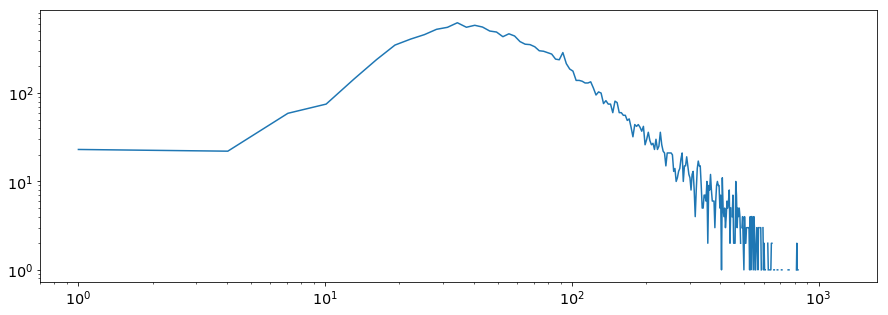

In [127]:
plt.plot(degreeBins_edges,degreeBins)
plt.yscale("log")
plt.xscale("log")
plt.show()

It's clear to see here that the graphs follow a poisson distribution. This is expected as most natural networks follow this distribution.

<h2> Graph of all movies

The initialisation of this graph is almost the same as for actors, we just turned it around with movies being nodes, and actors in common make edges.
After that we do the same actions to the graphs.

In [17]:
movieGraph = nx.Graph()
for filename in os.listdir('DoneMovies'):
    #print filename[:-4]
    fileOpen = io.open("DoneMovies/" + filename, 'r', encoding='utf-8')
    movieJson = json.load(fileOpen)
    fileOpen.close()
    movieGraph.add_node(str(movieJson["id"]))
    #break

In [18]:
for filename in os.listdir('ActorsMoreThan1'):
    fileOpen = io.open("ActorsMoreThan1/" + filename, 'r', encoding='utf-8')
    doneList = fileOpen.readlines()
    doneList = [x.strip() for x in doneList]
    fileOpen.close()
    for i in doneList:
        try:
            movieGraph.node[str(i)]
            for j in doneList:
                try:
                    movieGraph.node[str(j)]
                    if str(i) != str(j):
                        movieGraph.add_edge(str(i),str(j))
                except:
                    pass
        except:
            pass
    #break
for i in movieGraph.nodes():
    if movieGraph.degree(i) == 0:
        movieGraph.remove_node(i)
        #print i

In [19]:
movieGiant = max(nx.connected_component_subgraphs(movieGraph), key=len)
moviePartition = community.best_partition(movieGiant)

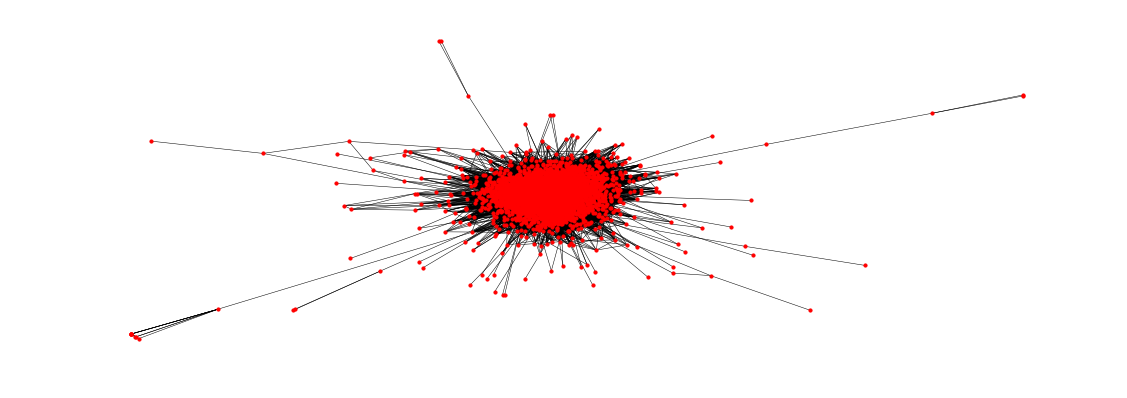

In [20]:
nx.draw(movieGiant, node_size = 10, width = 0.5)

plt.show()

Again we have taken the giant component of the Graph and worked from there. Above is the graph of all movies, connected by actors in common with other movies.

In [21]:
movieBetweenCent = nx.betweenness_centrality(movieGiant)

In [ ]:
from collections import Counter
movieList = Counter(movieBetweenCent).most_common(5)
for i in movieList:
    movie = io.open("MovieDBID/" + i[0] + ".txt", 'r', encoding='utf-8')
    movieJson = json.load(movie)
    nameDone = movieJson["title"]
    movie.close()
    print nameDone

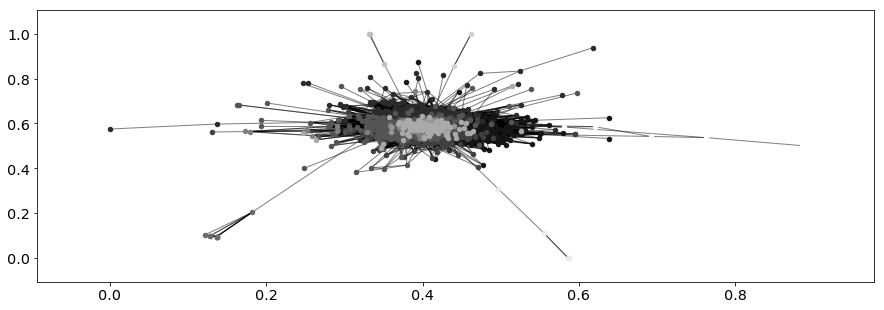

In [23]:
size = float(len(set(moviePartition.values())))
pos = nx.spring_layout(movieGiant)
count = 0.
for com in set(moviePartition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in moviePartition.keys()
                                if moviePartition[nodes] == com]
    nx.draw_networkx_nodes(movieGiant, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))
nx.draw_networkx_edges(movieGiant,pos, alpha=0.5)
plt.show()

Again we can see the graph, but with the partitions as different colors. This shows how the different partitions group together.

In [24]:
Mod = community.modularity(moviePartition, movieGiant)
print Mod

0.227610039976


In [25]:
communitiesNumber = max(moviePartition.values())
print "Number of communities : ", communitiesNumber

Number of communities :  11


Above we can see the number of partitions. This would initially seem like a good enough partioning, but if we look below, we can the the amount of nodes in each partition. This shows how there are some few partitions with very few nodes.

This tells us there are some few movies which only contains the same actors, and share very few with the rest of the Graph. This could for example be movies from a small studio or a small country.

In [26]:
testList = moviePartition.values()
for i in set(moviePartition.values()):
    print testList.count(i)

1275
1009
944
897
9
44
47
117
3
3
4
5


In [28]:
testList = []
for i in set(moviePartition.values()):
    testList.append([])
for node, part in moviePartition.iteritems():
    testList[part].append(node)
M = 0.0
for i in testList:
    Lc = 0.0
    L = len(movieGiant.edges())
    Kc = 0.0
    for j in i:
        Kc = Kc + movieGiant.degree(j)
        for l in movieGiant[j].keys():
            if l in i:
                Lc = Lc + 1        
    print "Lc =", Lc, ",", "L =", L, "Kc =", Kc
    tempM = ((Lc / L) - (Kc/(2*L))**2)
    M = M + tempM
    print "M =", tempM
print "Sum Modularity for all the branches :", M

Lc = 69766.0 , L = 269175 Kc = 142585.0
M = 0.189036068582
Lc = 60446.0 , L = 269175 Kc = 119598.0
M = 0.17520668004
Lc = 62144.0 , L = 269175 Kc = 130015.0
M = 0.172543026405
Lc = 43570.0 , L = 269175 Kc = 114541.0
M = 0.116596832785
Lc = 58.0 , L = 269175 Kc = 59.0
M = 0.000215461194291
Lc = 1002.0 , L = 269175 Kc = 6014.0
M = 0.00359769030663
Lc = 2082.0 , L = 269175 Kc = 8065.0
M = 0.00751031588157
Lc = 4292.0 , L = 269175 Kc = 17435.0
M = 0.0148961645591
Lc = 6.0 , L = 269175 Kc = 7.0
M = 2.22901624986e-05
Lc = 6.0 , L = 269175 Kc = 7.0
M = 2.22901624986e-05
Lc = 8.0 , L = 269175 Kc = 9.0
M = 2.97201626085e-05
Lc = 10.0 , L = 269175 Kc = 15.0
M = 3.71497762725e-05
Sum Modularity for all the branches : 0.679713690017


Above we have done modularity for the partitioning. Our sum of modularity is quite high, which tells us our partitioning is actually quite good. 
This confirms our suspicion of the smaller sub graphs and small groups of movies.

In [128]:
d = list(movieGraph.degree().values())
averageDegree = numpy.average(d)
print averageDegree
medianDegree = numpy.median(d)
print medianDegree

123.503555861
116.0


In [129]:
limitedInList = Counter(d).most_common(10)
print limitedInList

[(115, 37), (116, 35), (118, 34), (120, 34), (132, 34), (90, 33), (110, 31), (95, 30), (161, 30), (107, 29)]


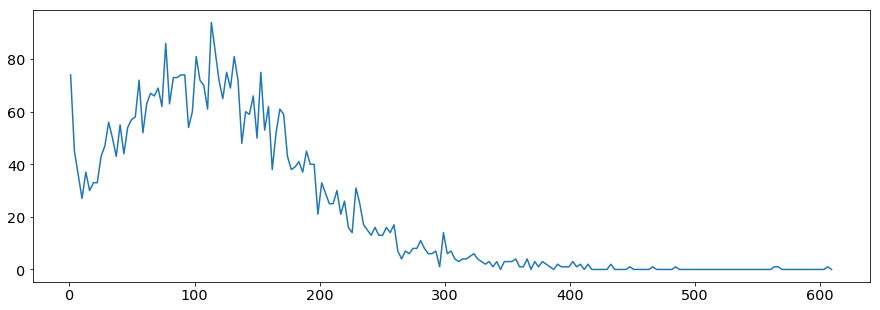

In [133]:
degreeValues = movieGraph.degree().values()
degreeBins,degreeBins_edges = numpy.histogram(degreeValues, bins=200)
degreeBins = numpy.append(degreeBins,0)
plt.plot(degreeBins_edges,degreeBins)
plt.show()

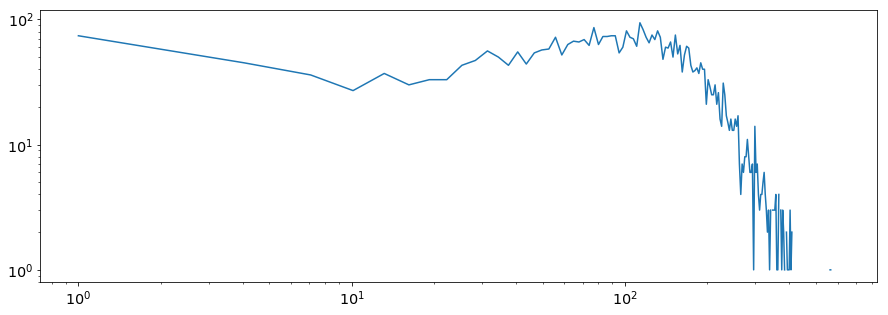

In [134]:
plt.plot(degreeBins_edges,degreeBins)
plt.yscale("log")
plt.xscale("log")
plt.show()

It's clear to see here that the graphs follow a poisson distribution. This is expected as most natural networks follow this distribution.

<h3> So in conclusion we can say we have plotted all our movies, with all edges in between them. From there we looked at the existence of smaller sub graphs inside, which we could prove. This shows us the existence of smaller groups of movies/actors who stay inside certain circles when making movies.
Lastly we looked at the average degree of movies and plotted the degree distribution.

<h2> Most profitable genre

In [135]:
maxRev = 0.0
maxRevGenre = ""
for filename in os.listdir('GenreList'):
    #print filename
    fileOpen = io.open("GenreList/" + filename, 'r', encoding='utf-8')
    doneList = fileOpen.readlines()
    doneList = [x.strip() for x in doneList]
    fileOpen.close()
    rev = 0.0
    for i in doneList:
        fileOpen2 = io.open("DoneMovies/" + i + ".txt", 'r', encoding='utf-8')
        sidensJson = json.load(fileOpen2)
        #filenOpen2.close()
        rev = rev + sidensJson["revenue"]
    rev = rev / len(doneList)
    if (rev > maxRev):
        maxRev = rev
        maxRevGenre = filename
    #break
print maxRevGenre, maxRev

Animation.txt 257318356.358


<h3> We have divided all our movies into lists of the different genre tag they have. From there we find the average revenue of all genres, and determine Animation to be the genre to have the highest average revenue for each movie.
So if one were to try and make money from movies, this would be the genre to do it in.

<h2> Best Actor Pair

<h3> The plan here is to find out which pair of two actors makes the movies with the highest revenue, and the highest score.

In [54]:
actorRevenueList = []
actorScoreList = []
count = 0

for filename in os.listdir('ActorPairs'):
    test = io.open("ActorPairs/" + filename, 'r', encoding='utf-8')
    doneList = test.readlines()
    doneList = [x.strip() for x in doneList]
    test.close()
    actorRevenue = 0.0
    actorScore = 0.0
    for i in doneList:
        filmen = io.open("MovieDBID/" + i + ".txt", 'r', encoding='utf-8')
        filmJson = json.load(filmen)
        actorRevenue = actorRevenue + filmJson["revenue"]
        actorScore = actorScore + filmJson["vote_average"]
        filmen.close()
    actorRevenue = actorRevenue / len(doneList)
    actorScore = actorScore / len(doneList)
    
    actorRevenueList.append([filename[:-4], actorRevenue])
    actorScoreList.append([filename[:-4], actorScore])
    #print count
    count = count + 1
    #break


In [55]:
actorRevenueSorted = sorted(actorRevenueList, key=lambda tup: tup[1], reverse=True)
actorScoreSorted = sorted(actorScoreList, key=lambda tup: tup[1], reverse=True)
for number in range(0,5):
    names = actorRevenueSorted[number][0] #Change this variable from actorRevenueSorted/actorScoreSorted
    name1 = names[:names.find("-")]
    name2 = names[names.find("-") +1:]
    filmen = io.open("ActorPairs/" + names + ".txt", 'r', encoding='utf-8')
    doneList = filmen.readlines()
    doneList = [x.strip() for x in doneList]
    filmen.close()

    person1 = io.open("PersonJson/" + name1 + ".txt", 'r', encoding='utf-8')
    name1Json = json.load(person1)
    name1Done = name1Json["name"]
    person1.close()

    person2 = io.open("PersonJson/" + name2 + ".txt", 'r', encoding='utf-8')
    name2Json = json.load(person2)
    name2Done = name2Json["name"]
    person2.close()
    print "__________"
    print name1Done, "and", name2Done
    for i in doneList:
        filmen2 = io.open("MovieDBID/" + i + ".txt", 'r', encoding='utf-8')
        filmJson = json.load(filmen2)
        print filmJson["title"]
        filmen.close()

__________
Warwick Davis and Domhnall Gleeson
Harry Potter and the Deathly Hallows: Part 1
Harry Potter and the Deathly Hallows: Part 2
Star Wars: The Force Awakens
__________
Scarlett Johansson and Jeremy Renner
The Avengers
Captain America: Civil War
Avengers: Age of Ultron
__________
Chris Evans and Jeremy Renner
The Avengers
Captain America: Civil War
Avengers: Age of Ultron
__________
Chris Evans and Paul Bettany
The Avengers
Captain America: Civil War
Avengers: Age of Ultron
__________
Jeremy Renner and Robert Downey Jr.
The Avengers
Captain America: Civil War
Avengers: Age of Ultron


<h3> As can be seen above, we've found the actor pairs, where they in average make the most money. 
If one where to change the variable "names" to take "actorScoreSorted" instead of "actorRevenueSorted", it would be clear the highest rated actor paris would be different combinations of the actors from the Lord of The Rings Triology.

<h2> Best Director and Actor Pair

The idea here is almost the same as above from actor pairs. Now we just look at Actor and Director pairs.

In [56]:
actorDirectorRevenueList = []
actorDirectorScoreList = []
count = 0
for filename in os.listdir('ActorDirectorPair'):
    test = io.open("ActorDirectorPair/" + filename, 'r', encoding='utf-8')
    doneList = test.readlines()
    doneList = [x.strip() for x in doneList]
    test.close()
    actorDirectorRevenue = 0.0
    actorDirectorScore = 0.0
    for i in doneList:
        filmen = io.open("MovieDBID/" + i + ".txt", 'r', encoding='utf-8')
        filmJson = json.load(filmen)
        actorDirectorRevenue = actorDirectorRevenue + filmJson["revenue"]
        actorDirectorScore = actorDirectorScore + filmJson["vote_average"]
        filmen.close()
    actorDirectorRevenue = actorDirectorRevenue / len(doneList)
    actorDirectorScore = actorDirectorScore / len(doneList)
    
    actorDirectorRevenueList.append([filename[:-4], actorDirectorRevenue])
    actorDirectorScoreList.append([filename[:-4], actorDirectorScore])
    #print count
    count = count + 1
    #break

In [57]:
actorDirectorRevenueSorted = sorted(actorDirectorRevenueList, key=lambda tup: tup[1], reverse=True)
actorDirectorScoreSorted = sorted(actorDirectorScoreList, key=lambda tup: tup[1], reverse=True)
for number in range(0,5):
    names = actorDirectorRevenueSorted[number][0] #Change this variable from actorDirectorRevenueSorted/actorDirectorScoreSorted
    name1 = names[:names.find("-")]
    name2 = names[names.find("-") +1:]
    filmen = io.open("ActorDirectorPair/" + names + ".txt", 'r', encoding='utf-8')
    doneList = filmen.readlines()
    doneList = [x.strip() for x in doneList]
    filmen.close()

    person1 = io.open("PersonJson/" + name1 + ".txt", 'r', encoding='utf-8')
    name1Json = json.load(person1)
    name1Done = name1Json["name"]
    person1.close()

    person2 = io.open("PersonJson/" + name2 + ".txt", 'r', encoding='utf-8')
    name2Json = json.load(person2)
    name2Done = name2Json["name"]
    person2.close()
    print "__________"
    print name1Done, "and", name2Done
    for i in doneList:
        filmen2 = io.open("MovieDBID/" + i + ".txt", 'r', encoding='utf-8')
        filmJson = json.load(filmen2)
        print filmJson["title"]
        filmen.close()
    

__________
Sigourney Weaver and James Cameron
Avatar
Aliens
__________
Mark Ruffalo and Joss Whedon
The Avengers
Avengers: Age of Ultron
__________
Scarlett Johansson and Joss Whedon
The Avengers
Avengers: Age of Ultron
__________
Stellan Skarsgård and Joss Whedon
The Avengers
Avengers: Age of Ultron
__________
Chris Evans and Joss Whedon
The Avengers
Avengers: Age of Ultron


<h3> As seen above we found the best pair of Actor/Director if you want revenue. At the top we have Sigourney Weaver/James Cameron. For the next many spots we have Joss Wheadon and the actors who were in The Avengers and Avengers: Age of Ultron. That is quite a large amount of people.

<H2> Review Word-Clouds <H2>

We are very interested in knowing more about the textual content of movie user-reviews. In particular we want to know more about trends of most common used words and whether they differ greatly between genres.

To get an idea of the most common words in used for each genre in their reviews we will utilize the WordCloud module. These WordClouds will visualize which words that characterize each genre and we can then make a general review WordCloud that encompasses all reviews to see if there are similarities.

In [5]:
#The review-text's will heavily favor stop-words and very common words in movie-reviews such as "movie" "film",
#but they tells us nothing about the genre so we will filter them out.
more_stopwords = {'movie', 'film', 'one'}
STOPWORDS = STOPWORDS.union(more_stopwords)

During our Data-formatting we made text files for each genre contaning the movie-id's for all movies that is tagged
with a specific genre-tag. We can now loop through each file and get the review text. Combining all the text we can then make the WordClouds.

WordCloud for the genre: Action


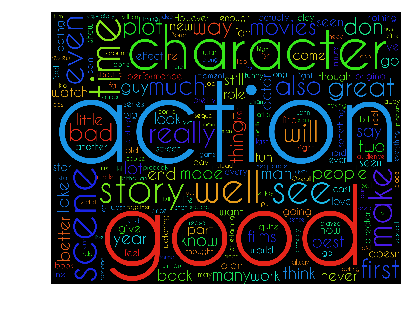

WordCloud for the genre: Adult


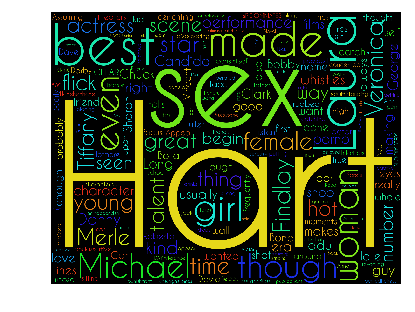

WordCloud for the genre: Adventure


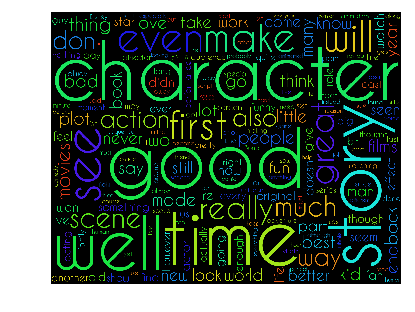

WordCloud for the genre: Animation


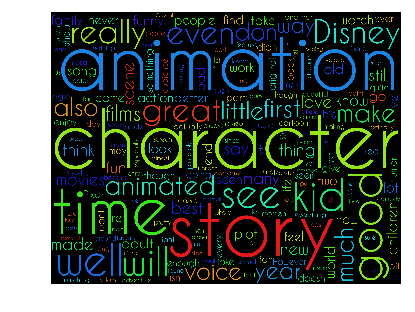

WordCloud for the genre: Biography


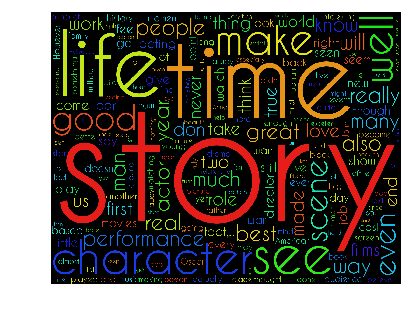

WordCloud for the genre: Comedy


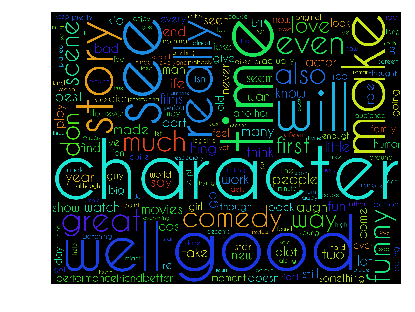

WordCloud for the genre: Crime


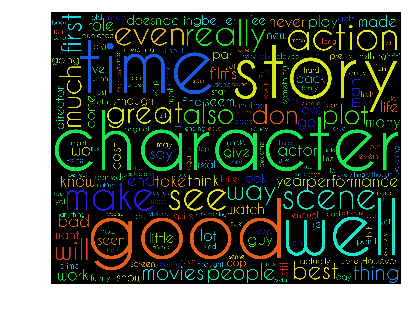

WordCloud for the genre: Documentary


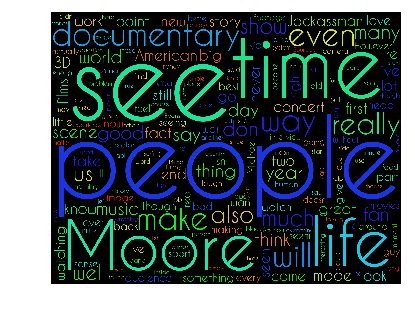

WordCloud for the genre: Drama


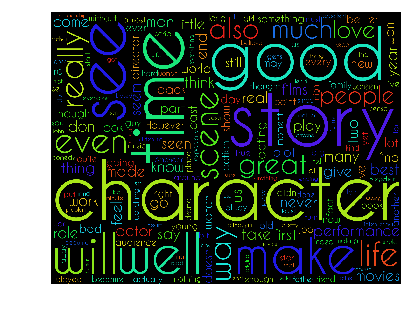

WordCloud for the genre: Family


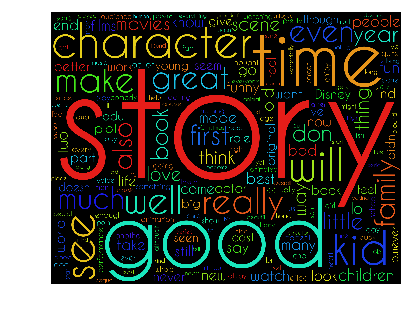

WordCloud for the genre: Fantasy


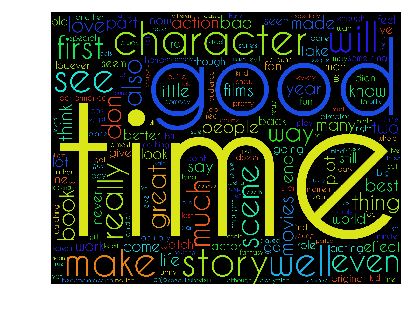

WordCloud for the genre: History


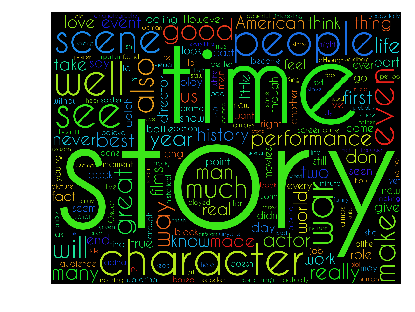

WordCloud for the genre: Horror


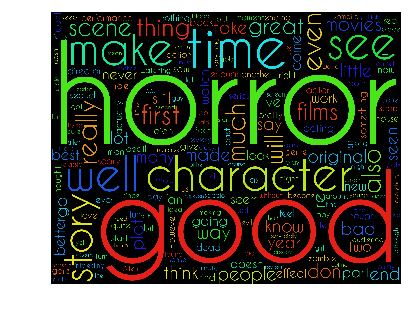

WordCloud for the genre: Music


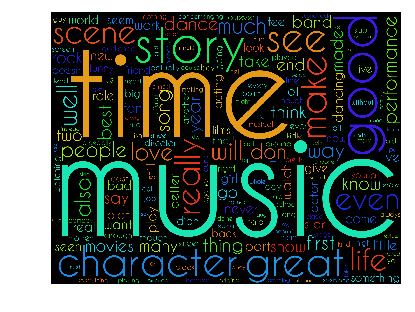

WordCloud for the genre: Musical


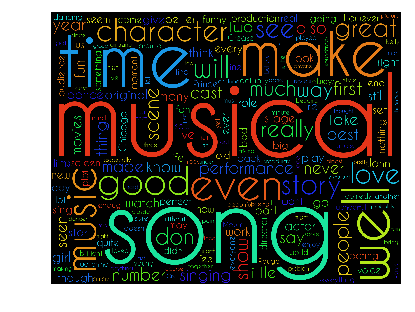

WordCloud for the genre: Mystery


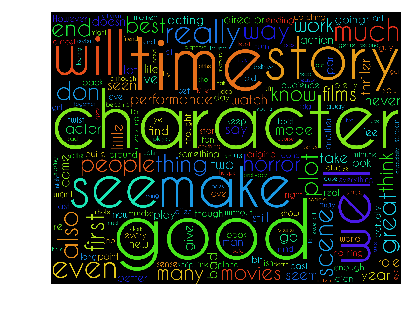

WordCloud for the genre: News


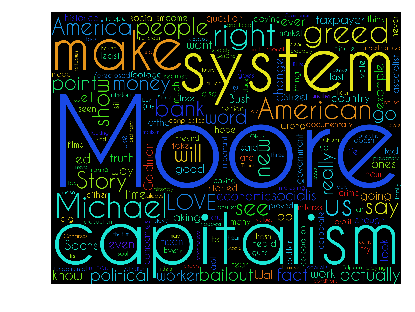

WordCloud for the genre: Romance


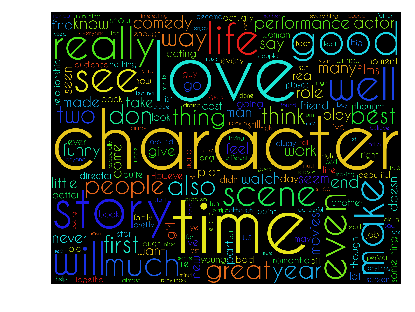

WordCloud for the genre: Sci-Fi


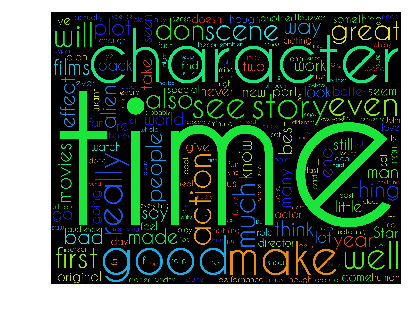

WordCloud for the genre: Sport


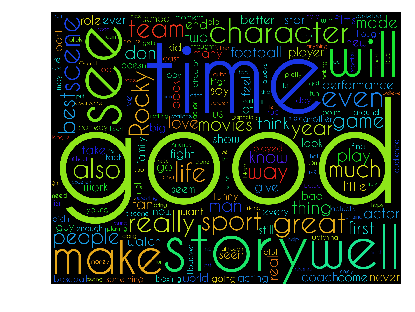

WordCloud for the genre: Thriller


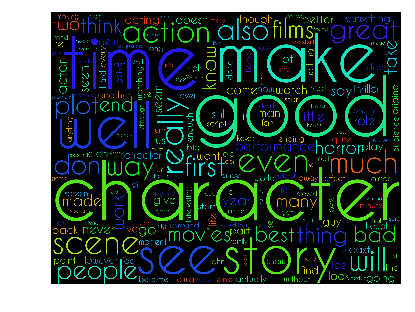

WordCloud for the genre: War


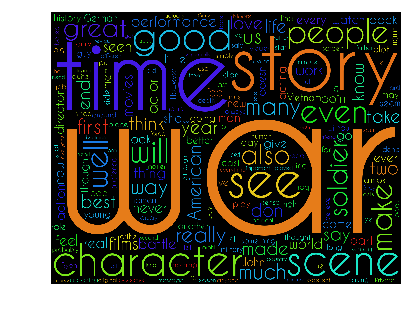

WordCloud for the genre: Western


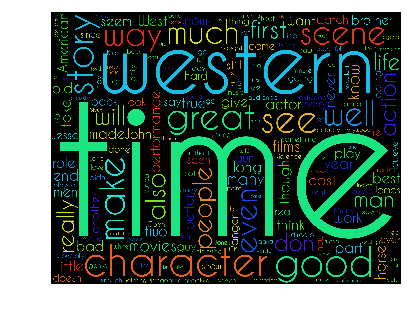

In [6]:
#loop through all genres
for genretype in os.listdir('GenreList'):
    moviesInGenre =  []
    with open("GenreList/"+ genretype) as f:
        #Get all lines of review text and remove end of lines
        moviesInGenre = f.readlines()
        moviesInGenre = [x.strip() for x in moviesInGenre] 
        Genre_Words = ""
        #Get all the review texts and join them into one
        for idd in moviesInGenre:
            with codecs.open("DoneMoviesReviews/" + idd + ".txt", "r", "utf-8") as myfile:
                #Remove unnecessary characters
                data=myfile.read().replace('\n', '')
                data=data.replace("<|_=00=_|>", "")
                data = re.sub('[^a-zA-Z0-9-_*.]', ' ', data)
                Genre_Words = Genre_Words + ''.join(data.encode('utf-8')) 
        #Create a WordCloud based on the entire review text and utilize the bag of stopwords.
        print "WordCloud for the genre:"+ " " +genretype[:-4]
        wordcloud = WordCloud(
                              font_path='CaviarDreams.ttf',
                              stopwords=STOPWORDS,
                              background_color='black',
                              width=1800,
                              height=1400
                             ).generate(Genre_Words)

        plt.imshow(wordcloud)
        plt.axis('off')
        plt.savefig('./'+ genretype[:-4]+ '.png', dpi=300)
        plt.show()        

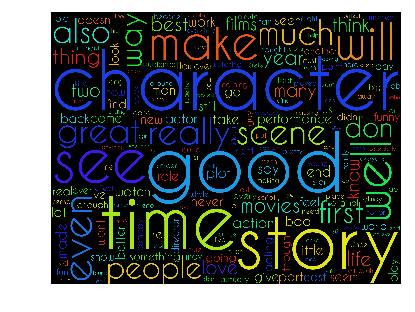

In [7]:
#Get all review texts
for f in os.listdir("DoneMoviesReviews/"):
    with codecs.open("DoneMoviesReviews/" + f[:-4] + ".txt", "r", "utf-8") as myfile:
        data=myfile.read().replace('\n', '')
        data=data.replace("<|_=00=_|>", "")
        data = re.sub('[^a-zA-Z0-9-_*.]', ' ', data)
        Genre_Words = Genre_Words + ''.join(data.encode('utf-8')) 
#Make a WordCloud for all reviews        
wordcloud = WordCloud(
                      font_path='CaviarDreams.ttf',
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(Genre_Words)

plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./AllGenre.png', dpi=300)
plt.show()        

It seems that most reviews across all genres will, more or less promiently, contain words such as: Character, Story, Time and Good. This makes sense as they usually are words necessary for describing a movie i.e. if they had to reference a character or whether they thought the story was good or bad. The commonality of these words are also show in the WordCloud for the combined review text, where they are among the major words used. 

However as there exist very common words shared between the genrne reviews, there are also some genre WordClouds that show some very distinct words that clearly seperates them and makes them easier to classify.
Some good examples of this is the News-Genre where the major words are several hot topic terms, most of which reference the market crash of 0'8 such as: Michael Moore, capitalism, America(n), Greed, Banks etc. The Romance genre also was easy to classify as it love among its most prominent used terms while the Animation reviews used the terms Kid and Disney alot.

So in conclusion the overall result of the WordClouds was mixed. We had hoped for the WordClouds to be more distinct in their characteriziation of their individual genres, but alot of them such as the Action genre didn't show many words one would distinctivly associate with the genre. We, however, still got some WordClouds which we would be able to label even without knowing the genre beforehand so it wasn't completly useless. 

<h1> Attribute correlation

The overall goal of the project is to find trends within the movie-business. Therefore we are very interested in finding correlations between differn't movie attributes which a part of our dataset.
We will now extract all the related data from our dataset and make some plots to try and visualize the possible correlations. However our main focus will be to utilize the very usefull Panda package to do the correlation calculations between all attributes using Panda Dataframes.

<h3>SENTIMENT</h3>

An interesting attribute to look into is the average sentiment-score for the reviews of a film.
By calculating the sentiment-score, we can see whether more positive reviews are an indicatior of a higher grossing movie or maybe that the movie-score are directly correlated to how people write about a movie.

The sentiment scores are calculated using LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1).
Which can be downloaded from http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752.

We were inspired by another group during assignment 2 in which they too used the LabMT wordlist, but had some great code that improved on the efficiency. Due to the fact that assignments are anonymized we cannot credit them, but we have utilized their code in next two cells.

In [10]:
#COPY CODE
# the LabMT wordlist can now be found at the path below.
# PREPARING THE DATA SET 
labmt = open('Data_Set_S1.txt','r').read()
labmt  =nltk.word_tokenize(labmt) # the set is tokenized, to be able to access the values as list elements
#labmt[labmt.index('laughter')+1]
labmt = labmt[labmt.index('laughter'):] # A little hard coding to remove problematic text from labmt set
# EXTRACT ONLY THE WORDS FROM THE DATA SET
words_in_labmt = re.findall('[\D]+',' '.join(labmt).translate(None, string.punctuation)) # find all words that are not digits                                                                                          #and remove punctuation
words_in_labmt = re.findall('[\S]+',' '.join(words_in_labmt)) # exclude whitespaces

In [11]:
#COPY CODE
#REMOVE ANY WORDS THAT HAVE BEEN GENERATED ABOVE, THAT ARE NOT IN LABMT
remove = set() # set of words to exclude from 'words_in_labmt'
labmt_valence = {} # dictionary to contain words from 'words_in_labmt' as keys and their corresponding valence as values.
for word in words_in_labmt: 
    if word not in labmt: 
        remove.add(word)  # add word to remove to 'remove' set
    else:
        valence = float(labmt[labmt.index(word)+2])  # get valence score from labmt
        if valence <= 10.0:          # check that valence score is within the expected interval. 
            labmt_valence[word] = valence               
        else: remove.add(word)   
# exclude the words in 'remove'-set from 'words_in_labmt':
words_in_labmt = set(words_in_labmt).difference(set(remove)) 

In [12]:
#Function for calculating the sentiment of a given list of tokens.
#Goes through each token in the list and adds it's sentiment value to the total.
#It then returns the total sentiment value divided by the number of words in the list,
#which is the average sentiment of the entire token list.
from __future__ import division
def sentiment(tokenList):
    sentimentScore = 0.0
    for w in tokenList:
        if w in words_in_labmt:
            word = w.lower()
            sentimentScore = sentimentScore + float(labmt_valence.get(word))
    if sentimentScore == 0.0:
        print "No Sentiment Words"
        return sentimentScore
    else:
        return sentimentScore/len(tokenList)

In [13]:
#Loop through all reviews and get their sentiement score
movieSentiment = {}
for f in os.listdir("DoneMovies/"):
    with codecs.open("DoneMoviesReviews/" + f[:-4] + ".txt", "r", "utf-8") as myfile:
        data=myfile.read().replace('\n', '')
        data=data.replace("<|_=00=_|>", "")
        data= re.sub('[^a-zA-Z0-9-_*.]', ' ', data)
        #Save the movie ID and the sentiment score in a dictonary
        movieSentiment[""+f[:-4]]=sentiment(data)

We have calculated the sentiment-score for all movies. The result suprised us as we had expected that the sentiment score would  have a large interval with some (surposed bad movies) scoring in the bottom while other movies would be in the top. This however didn't occur and instead the interval only runs from 3.62 to 4.05. One explanation could be that it our review text wasn't large enough to get a good interpretation of the score or maybe the user written reviews had too many typos that it started to effect the score.

In [14]:
print sorted(movieSentiment.values())[:10]
print sorted(movieSentiment.values(), reverse = True)[:10]

[3.6179115584017802, 3.6542073793202716, 3.680612808408223, 3.687155570424743, 3.688344827586197, 3.691254752851643, 3.69287356321839, 3.7023720552396417, 3.702385396276194, 3.708941592920214]
[4.054541108986618, 4.015226411075605, 4.011636243821866, 4.0020534790958555, 3.993211626574829, 3.987272583075448, 3.98676448073465, 3.983348328481988, 3.982735312341372, 3.9813453318334786]


<h3>SCORE</h3>
The movie-score is a great way to get an understanding of how people perceive a movie and be able to seperate good and bad movies from each other. 

In [15]:
movieScore = {}
for f in os.listdir("DoneMovies/"):
    jsondata = io.open("DoneMovies/" + f, 'r', encoding='utf-8')
    sidensJson = json.load(jsondata)
    movieScore[""+f[:-4]]=sidensJson["vote_average"]
    jsondata.close()

The scores are very diverse with an interval from 1.9 to 10.0 and thereby great to se if there is an correlation.

In [16]:
print sorted(movieScore.values())[:10]
print sorted(movieScore.values(), reverse = True)[:10]

[1.9, 2.0, 2.3, 2.6, 2.8, 3.0, 3.0, 3.0, 3.0, 3.0]
[10.0, 9.0, 8.7, 8.6, 8.5, 8.5, 8.5, 8.4, 8.3, 8.3]


<h3>Budget</h3>

In [17]:
movieBudget = {}
for f in os.listdir("DoneMovies/"):
    jsondata = io.open("DoneMovies/" + f, 'r', encoding='utf-8')
    sidensJson = json.load(jsondata)
    movieBudget[""+f[:-4]]=sidensJson["budget"]
    jsondata.close()

The budgets has a high varity going from tens-of-thousands to hundreds-of-millions which tells us that we are working with both indie movies as well as big blockbusters.

In [18]:
print sorted(movieBudget.values())[:10]
print sorted(movieBudget.values(), reverse = True)[:10]

[10000, 11178, 11180, 15000, 17000, 20000, 22361, 22361, 22361, 24554]
[380000000, 300000000, 280000000, 270000000, 260000000, 260000000, 258000000, 255000000, 250000000, 250000000]


In [19]:
movieRevenue = {}
for f in os.listdir("DoneMovies/"):
    jsondata = io.open("DoneMovies/" + f, 'r', encoding='utf-8')
    sidensJson = json.load(jsondata)
    movieRevenue[""+f[:-4]]=sidensJson["revenue"]
    jsondata.close()

The income has a high varity going from tens-of-thousands to billions.

In [20]:
print sorted(movieRevenue.values())[:10]
print sorted(movieRevenue.values(), reverse = True)[:10]

[10000, 10018, 10289, 10300, 10474, 11276, 11455, 12000, 12762, 13308]
[2787965087L, 2068223624, 1845034188, 1519557910, 1513528810, 1506249360, 1405403694, 1342000000, 1274219009, 1262886337]


<h3>Gross Income<h3>

In [21]:
movieIncome = {}
for f in os.listdir("DoneMovies/"):
    jsondata = io.open("DoneMovies/" + f, 'r', encoding='utf-8')
    sidensJson = json.load(jsondata)
    movieIncome[""+f[:-4]]=(sidensJson["revenue"] - sidensJson["budget"])
    jsondata.close()

The gross income has a high varity going from losses of millions to profits of billions which tells us that we are working with both very successfull movies as well as large commerical failures.

In [22]:
print sorted(movieIncome.values())[:10]
print sorted(movieIncome.values(), reverse = True)[:10]

[-165710090, -119180039, -111007242, -98301101, -92896027, -87982678, -85321445, -84540684, -80445998, -79627709]
[2550965087L, 1823223624, 1645034188, 1363528810, 1316249360, 1299557910, 1217000000, 1125403694, 1124219009, 1102886337]


<h3>Gross Income Ratio</h3>

The gross income ratio is a funny attribute as tells whether a movie is a huge sleeper hit, with a very low-budget but a huge income which should make for some big varity in the values.

In [23]:
movieIncomeRatio = {}
for f in os.listdir("DoneMovies/"):
    jsondata = io.open("DoneMovies/" + f, 'r', encoding='utf-8')
    sidensJson = json.load(jsondata)
    movieIncomeRatio[""+f[:-4]]=(sidensJson["revenue"] / sidensJson["budget"])
    jsondata.close()

As expected the values makes a great interval with the low-end ratio's under 1 to insanely high ratio's going as high as 12890. 

In [24]:
print sorted(movieIncomeRatio.values())[:10]
print sorted(movieIncomeRatio.values(), reverse = True)[:10]

[0.00051445, 0.00087395, 0.0011339384615384614, 0.0012, 0.0012882424242424242, 0.0013586666666666667, 0.0014, 0.0015333333333333334, 0.0017472, 0.00205725]
[12890.386666666667, 4133.333333333333, 700.0, 439.6165846153846, 426.6441, 420.52272307692306, 262.8199991055856, 250.0, 215.3846153846154, 155.84255]


<h3>SCATTER PLOTS</h3>

We will make some scatterplots to illustrate some of the more interesting correlations that we wish to investigate.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

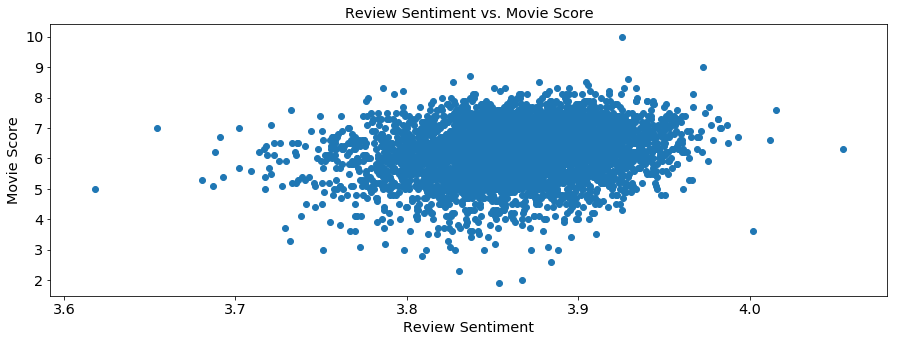

In [26]:
plt.scatter(movieSentiment.values(), movieScore.values())
plt.title("Review Sentiment vs. Movie Score")
plt.xlabel("Review Sentiment")
plt.ylabel("Movie Score")
plt.show()

The graph shows a scatter-plot between Review Sentiment and Movie Score. The plot shows that there is a small-ish correlation going towards one which means that when a movies score is high, there more then average that results in the reviews also using more sentimental words.

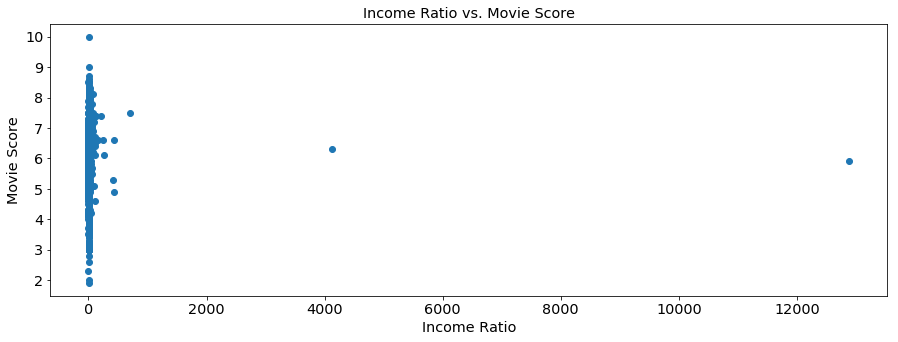

In [27]:
plt.scatter(movieIncomeRatio.values(), movieScore.values())
plt.title("Income Ratio vs. Movie Score")
plt.xlabel("Income Ratio")
plt.ylabel("Movie Score")
plt.show()

We were interested in whether there could be an correlation between the income ratio and the movie scores as to say that the movies people like the most also makes the most money back. However due to the insane value interval there exist some outliers that makes it hard to come any conclusion. To amend this we will make another plot where we limit the income ratio to at most 75.

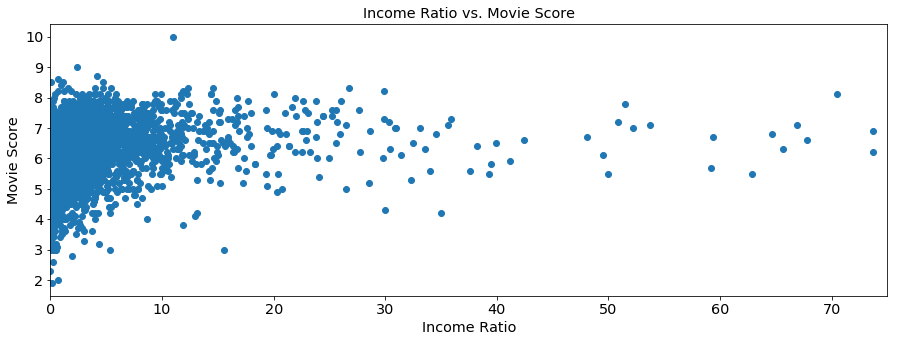

In [28]:
plt.scatter(movieIncomeRatio.values(), movieScore.values())
plt.title("Income Ratio vs. Movie Score")
plt.xlabel("Income Ratio")
plt.ylabel("Movie Score")
plt.xlim([0,75])
plt.show()

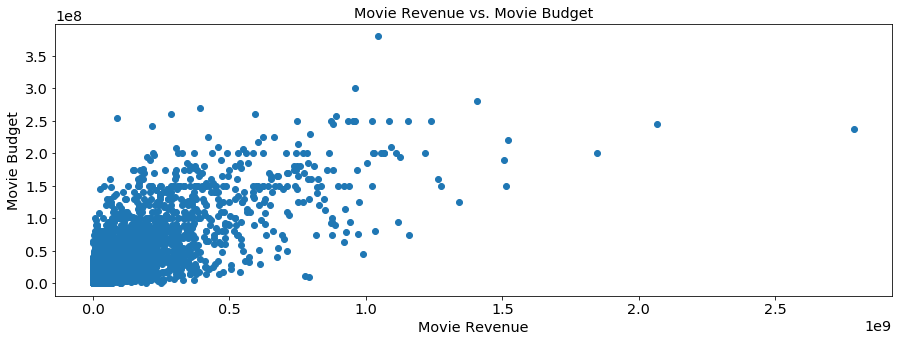

In [29]:
plt.scatter(movieRevenue.values(), movieBudget.values())
plt.title("Movie Revenue vs. Movie Budget")
plt.xlabel("Movie Revenue")
plt.ylabel("Movie Budget")
plt.show()

The most important correlation for developing movies is whether revnue and budgets has an impact on each other. The scatter-plot shows a clear positive correlation which tells us that pouring money into a movie more often then not means that it will directly influence the income later on.

<h3>Attribute Correlation</h3>

The actual correlations will be calculated using the Panda DataFrame. Due to the fact that all movies had its attributes collected in the same order we can simply give the DataFrame the values of each dictionary and have them match up.

In [30]:
import pandas as pd

In [32]:
datamatrix = pd.DataFrame({'User Score': movieScore.values(),'Sentiment': movieSentiment.values(),'Budget': movieBudget.values(), 'Gross Income': movieIncome.values(), 'Income Ratio': movieIncomeRatio.values(), 'Revenue': movieRevenue.values()})

In [33]:
datamatrix.corr()

,Budget,Gross Income,Income Ratio,Revenue,Sentiment,User Score
Budget,1.000000,0.582307,-0.022553,0.727765,-0.069845,0.069169
Gross Income,0.582307,1.000000,0.025510,0.981338,-0.063111,0.259909
Income Ratio,-0.022553,0.025510,1.000000,0.016186,-0.016669,0.002273
Revenue,0.727765,0.981338,0.016186,1.000000,-0.069761,0.235622
Sentiment,-0.069845,-0.063111,-0.016669,-0.069761,1.000000,0.216589
User Score,0.069169,0.259909,0.002273,0.235622,0.216589,1.000000


The outcome of the correlation-matrix for the movie attributes gave some interesting results. Firstly as earlier show in the scatter-plots the budget and income has high correlation with each other. This also the case with the gross income, which isn't suprising considering it was calculated using both of them. However the income ratio shows no correlation at all between any of the other attributes which is a surprise. The most interesting results came with the sentiment and user scores. The sentiment didn't have a correlation to the income or budget of any movies but showed a correlation with the movie score which proves the hypothesis that people who like a movie more tends to write more sentimentality about it. The user score in contrast to the sentiment showed smaller correlations with the revenue and gross income which tells us that the more people like a movie the more likely it is to make money.

<h1>Discussion</h1>


So what went right in this project?
Our work with the MovieDB Api was really good. We experienced almost no problems with the API and their data structure was really good. They did have a limit on a maximum of 4 calls per second which was a bit of a problem considering the size of our data set.
Besides that, our work with Word Clouds was also very good. There was no problems with this package and everything worked as intended.

Besides this we were also very happy with our results from the Correlations part and Betweenes in our graphs. Both showed interesting information which we wouldn't have got by other means than doing this project. 

But there are also things we would have changed if we started over. For example, our data set is really big. That created a lot of waiting time and hassle when scaling to the full data set. So if we could, we would probably have chosen a data set of maybe a quarter size. It's also possible to do the same size, but then the code should either have been on servers, or have been very well timed during the day.
We also tried to get TD-IDF to work on our dataset, but we didn't quite get it to work on our whole data set.